In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [2]:
def make_hydrogen_hamiltonian_hea(distance: float) -> (QuantumCircuit, QuantumCircuit):
    """
    Create a reduced 2-qubit Hamiltonian for a hydrogen molecule with given H-H distance.

    Args:
        distance (float): The distance between the two hydrogen atoms in angstroms.

    Returns:
        QuantumCircuit: The Hamiltonian as a quantum circuit.
    """
    driver = PySCFDriver(
        atom=f'H 0 0 0; H 0 0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    problem = driver.run()
    mapper = ParityMapper(num_particles=problem.num_particles)
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')

    ansatz = QuantumCircuit(2)
    ansatz.ry(theta1, 0)
    ansatz.ry(theta2, 1)
    ansatz.cx(0, 1)
    return (mapper.map(problem.hamiltonian.second_q_op()), ansatz)

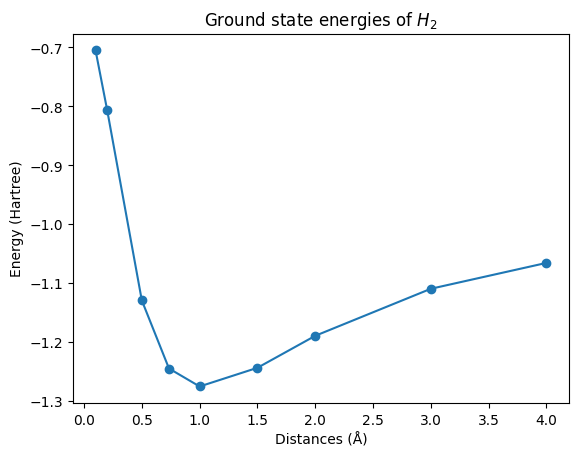

In [3]:
# SIMULATOR
optimizer = L_BFGS_B()
estimator = StatevectorEstimator()
distance_shots=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]
convergences = []
# iterations_of_convergences = [[] for _ in range(len(distance_shots))]

for i in distance_shots:
    (qubit_hamiltonian, ansatz) = make_hydrogen_hamiltonian_hea(i)
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        # iterations_of_convergences[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    convergences.append(result)

energies = [res.fun for res in convergences]
plt.plot(distance_shots, energies, marker='o', linestyle='-')
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()

In [ ]:
# Num of qubits
print(f"Num of qubits: {ansatz.num_qubits}")
# Num of parameters
print(f"Num of parameters: {ansatz.num_parameters}")
# Depth
print(f"Depth of ansatz: {ansatz.depth()}")
# Accuracy
print("Expected energy: -1.1373 Hartree")
print(f"Final energy: {result.fun} Hartree")
print(f"Accuracy: {abs(result.fun + 1.1373)} Hartree")
# Iterations
print(f"Average num of iterations: {result.nit}")
# 